# The complexity of Generative adversarial network loss surface

This notebook recreates the experiments in the eponymous paper. Most of the work revolves around solving a certain quartic numerically, correctly choosing its roots and applying numerical quadrature on its solutions.

In [2]:
%load_ext autoreload
%autoreload 2
from functools import partial
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import os 
import pickle as pkl
import seaborn as sns
from tqdm import tqdm 

from complexity import theta, in_integration_domain
from constants import b_constants, univariate_gaussian_variances, complexity_constant, integration_region
from coulomb import log_complexity_exponent, log_complexity_exponent_index, log_determinant
from spectrum import density, support
from empirical import sample_spectra, sample_spectrum, mc_log_determinant
%matplotlib inline


Ignoring warnings isn't great practice, but they spam the output here, particularly later on when using parallel processing.

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Limiting spectral density

Find numerically the LSD of $$H = bM + b_1\left(\begin{array}{cc} M_1 & 0 \\ 0 & 0\end{array}\right) - x_1\left(\begin{array}{cc} I & 0 \\ 0 & 0\end{array}\right)$$ and compre with generated data from finite matrices.

Let's try with a generic set of parameters.

In [3]:
def compare_spectra(x1, kappa, b, b1, N):
    lsd = partial(density, x1=x1, kappa=kappa, b=b, b1=b1)
    spectrum = np.concatenate(sample_spectra(n_samples=100, x1=x1, kappa=kappa, b=b, b1=b1, dimension=N))
    sns.distplot(spectrum, kde=False, norm_hist=True, label="{}x{} matrices".format(N, N));

    z = np.linspace(-3-x1*b, 2*b, 1000)
    lims = support(x1, b, b1)
    z = np.linspace(lims[0], lims[1], 1000)
    d = np.array([lsd(zz) for zz in z])
    plt.plot(z, d, label="LSD");
    plt.legend();

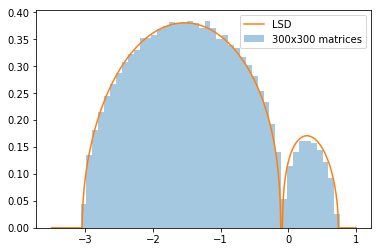

In [28]:
x1=1.5
kappa=0.9
b=1
b1=0.5
N = 300

compare_spectra(x1, kappa, b, b1, N)
plt.savefig("figures/spectrum_touching.pdf")

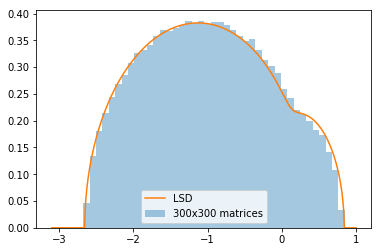

In [29]:
x1=1.1
compare_spectra(x1, kappa, b, b1, N)
plt.savefig("figures/spectrum_merged.pdf")

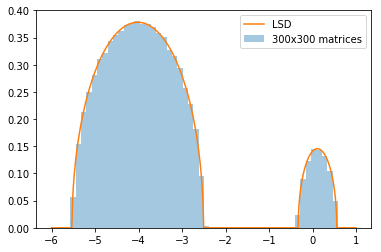

In [30]:
x1=4
compare_spectra(x1, kappa, b, b1, N)
plt.savefig("figures/spectrum_separate.pdf")

## Exponent function 

We use the Coulomb gas approximation to compute the log expected determinant of the Hessain (H) to leading order.

$$H = bM + b_1\left(\begin{array}{cc} M_1 & 0 \\ 0 & 0\end{array}\right) - x_1\left(\begin{array}{cc} I & 0 \\ 0 & 0\end{array}\right)$$

$$\mathbb{E} |\det H - x| \approx \exp\left(N\int\log|\lambda - x| d\mu_{eq}(\lambda)\right)$$

$$C_N \approx K_N \iint_B dxdx_1  \exp\left\{-N\left(\frac{x^2}{2s^2}+ \frac{x_1^2}{2s_1^2} - \int\log|\lambda - x| d\mu_{eq}(\lambda)\right)\right\}$$

We start by comparing the result of this approximation to numerical calculation of the expected log determinant using finite dimension matrix samples and Monte Carlo averaging.

In [7]:
p, q, sigma_z, kappa = 2, 2, 0.1, 0.3

x1 = np.linspace(-10, 10, 10)
x = np.linspace(-10, 5, 50)
N = 50

mc_det_vals = np.zeros((len(x1), len(x)))
det_vals = mc_det_vals.copy()

b, b1 = b_constants(p, q, sigma_z, kappa)

det = np.vectorize(partial(log_determinant, kappa=kappa, b=b, b1=b1))
mc_det = np.vectorize(partial(mc_log_determinant, b=b, b1=b1, kappa=kappa, n_samples=50, dimension=N))

for x1ind, x1_v in tqdm(enumerate(x1)):
    mc_det_vals[x1ind] = mc_det(x, x1_v)
    det_vals[x1ind] = det(x, x1_v)

10it [02:12, 13.69s/it]


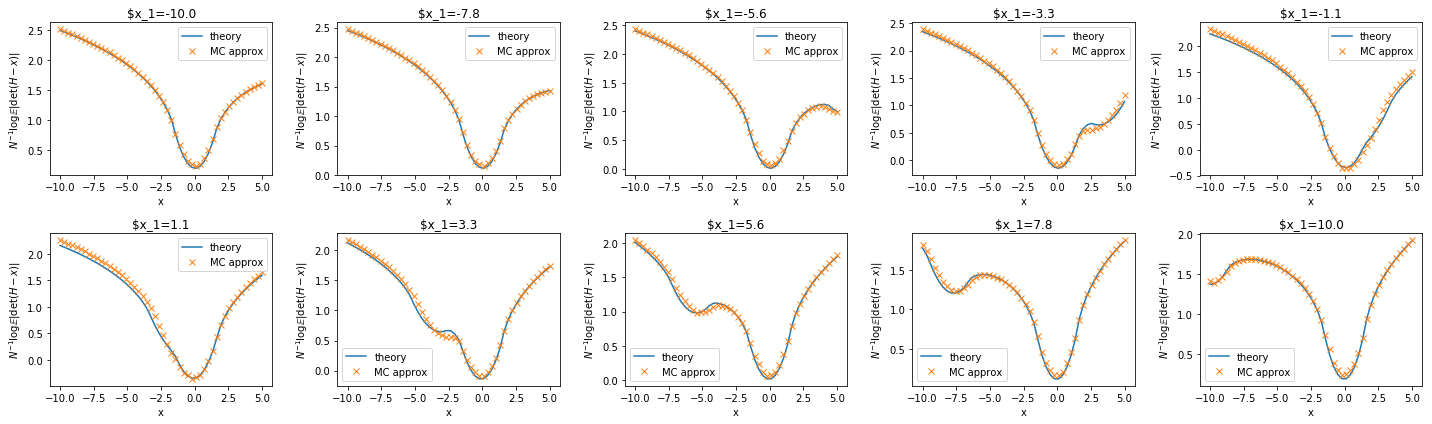

In [8]:
plt.figure(figsize=(20, 6));
for x1ind, x1_v in enumerate(x1):
    plt.subplot(2, 5, x1ind+1);
    plt.plot(x, det_vals[x1ind], label="theory");

    plt.plot(x, mc_det_vals[x1ind], 'x', label="MC approx");
    plt.xlabel('x');
    plt.title('$x_1$={:.1f}'.format(x1_v));
    plt.legend();
    
    plt.ylabel("$N^{-1}\log\mathbb{E}|\det(H-x)|$");
plt.legend();
plt.tight_layout();
plt.savefig("figures/numerical_coulomb_verification.pdf");

We get nice agreement for the Coulomb approximation, even at low $N$.

Now let's plot the exponent function in 2d and the marginals.

In [42]:
p, q, sigma_z, kappa = 2, 2, 0.1, 0.3

b, b1 = b_constants(p, q, sigma_z, kappa)
C = complexity_constant(p, q, sigma_z, kappa)
s_sq, s1_sq = univariate_gaussian_variances(p, q, sigma_z)

exp = np.vectorize(partial(log_complexity_exponent, b=b, b1=b1, kappa=kappa, constant=C, s_sq=s_sq, s1_sq=s1_sq))

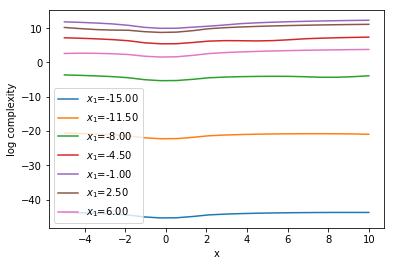

In [47]:
x1 = np.linspace(-15, 6, 7)
x = np.linspace(-5, 10, 20)

e = np.array([exp(x, x1v) for x1v in x1])

# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1);
for x1_val, es in zip(x1, e):
    plt.plot(x, es, label="$x_1$={:.2f}".format(x1_val));
    plt.xlabel("x");
    plt.ylabel("log complexity");
    # plt.subplot(1, 2, 2);
    # plt.plot(x, np.maximum.accumulate(e));
    # plt.xlabel("x");
    # plt.ylabel("rolling maximum log complexity");
    plt.legend();
plt.savefig("figures/exponent_marginal_x.pdf")

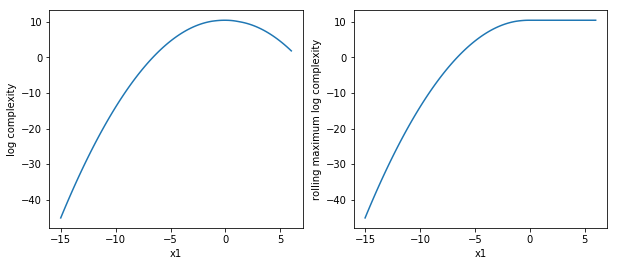

In [12]:
x = np.linspace(-25, 10, 7)
x1 = np.linspace(-15, 6, 100)

e = np.array([exp(xv, x1) for xv in x])

for x_val, es in zip(x, e):
    plt.plot(x1, es, label="$x$={:.2f}".format(x_val));
    plt.xlabel("$x_1$");
    plt.ylabel("log complexity");
    # plt.subplot(1, 2, 2);
    # plt.plot(x, np.maximum.accumulate(e));
    # plt.xlabel("x");
    # plt.ylabel("rolling maximum log complexity");
plt.savefig("figures/exponent_marginal_x1.pdf")

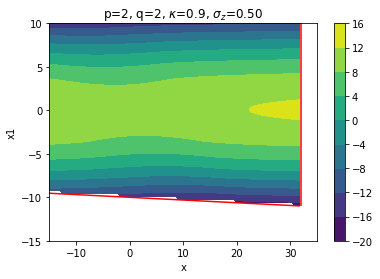

In [13]:
p = q = 2
kappa = 0.9
sigma_z = .5

x = np.linspace(-15, 35, 75)
x1 = np.linspace(-15, 10, 75)
x, x1 = np.meshgrid(x, x1)

b, b1 = b_constants(p, q, sigma_z, kappa)
C = complexity_constant(p, q, sigma_z, kappa)
s_sq, s1_sq = univariate_gaussian_variances(p, q, sigma_z)
exp = np.vectorize(partial(log_complexity_exponent, b=b, b1=b1, kappa=kappa, constant=C, s_sq=s_sq, s1_sq=s1_sq))

e = exp(x, x1)

P, Q, R = integration_region(5, 0.5, p, q)
in_domain = partial(in_integration_domain, P=P, Q=Q, R=R)

plot_vals = e.copy()
in_dom = in_domain(x, x1)
plot_vals[~in_dom] = np.nan
plt.contourf(x, x1, np.real(plot_vals))
plt.colorbar();

plt.plot(x[x<P], R*x[x<P] + Q, c='r');
plt.vlines([P], [R*P+Q], [x1.max()], color='r');

plt.xlabel("x");
plt.ylabel("x1");
plt.title("p={}, q={}, $\kappa$={:.1f}, $\sigma_z$={:.2f}".format(p,q,kappa,sigma_z));
plt.savefig("figures/exponent_in_domain.pdf");

In [14]:
uD, uG, theta_vals = theta(x, x1, np.real(e), p, q)

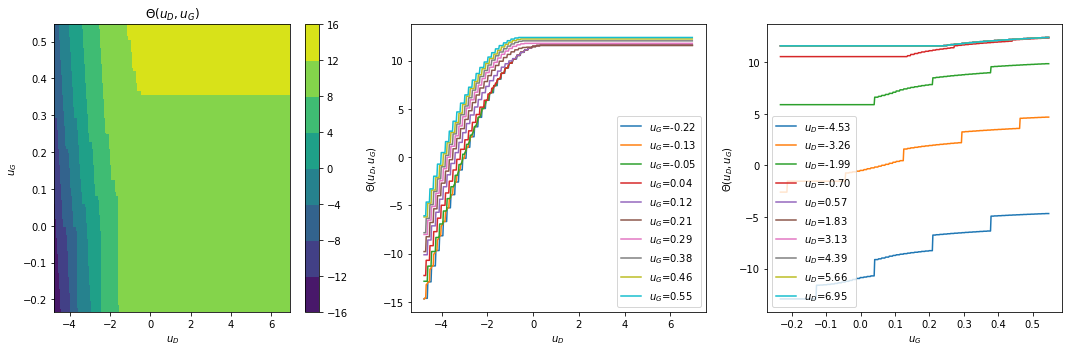

In [15]:
plt.figure(figsize=(15, 5));

plt.subplot(1, 3, 1);
plt.contourf(uD, uG, theta_vals);
plt.colorbar();
plt.title("$\Theta(u_D, u_G)$");
plt.xlabel("$u_D$");
plt.ylabel("$u_G$");



plt.subplot(1, 3, 2);
for row_ind in np.linspace(10, uD.shape[0]-1, 10):
    row_ind = int(row_ind)
    plt.plot(uD[row_ind], theta_vals[row_ind], label="$u_G$={:.2f}".format(uG[row_ind, 0]));
plt.legend();
plt.ylabel("$\Theta(u_D, u_G)$");
plt.xlabel("$u_D$");

plt.subplot(1, 3, 3);
for col_ind in np.linspace(10, uG.shape[1]-1, 10):
    col_ind = int(col_ind)
    plt.plot(uG[:, col_ind], theta_vals[:, col_ind], label="$u_D$={:.2f}".format(uD[0, col_ind]));
plt.legend();
plt.ylabel("$\Theta(u_D, u_G)$");
plt.xlabel("$u_G$");

plt.tight_layout();

plt.savefig("figures/theta.pdf")

### Index specific complexity

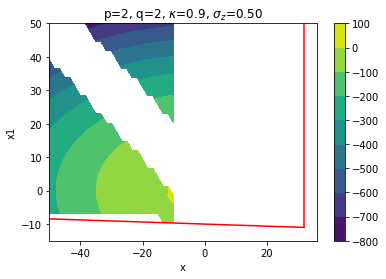

In [3]:
p = q = 2
kappa = 0.9
sigma_z = .5
kd, kg = 1, 1


b, b1 = b_constants(p, q, sigma_z, kappa)
max_x = np.sqrt(2 * (1 - kappa)) * b * 1.05


x = np.linspace(-50, max_x, 75)
x1 = np.linspace(-15, 50, 75)
x, x1 = np.meshgrid(x, x1)


C = complexity_constant(p, q, sigma_z, kappa)
s_sq, s1_sq = univariate_gaussian_variances(p, q, sigma_z)
exp = np.vectorize(partial(log_complexity_exponent_index, b=b, b1=b1, kappa=kappa, constant=C, s_sq=s_sq, s1_sq=s1_sq, kd=kd, kg=kg))

e = exp(x, x1)

P, Q, R = integration_region(5, 0.5, p, q)
in_domain = partial(in_integration_domain, P=P, Q=Q, R=R)

plot_vals = e.copy()
in_dom = in_domain(x, x1)
plot_vals[~in_dom] = np.nan
plt.contourf(x, x1, np.real(plot_vals))
plt.colorbar();

domain_boundary_x = np.linspace(np.min(x), max(np.max(x), P), 500)
plt.plot(domain_boundary_x, R*domain_boundary_x + Q, c='r');
plt.vlines([P], [R*P+Q], [x1.max()], color='r');

plt.xlabel("x");
plt.ylabel("x1");
plt.title("p={}, q={}, $\kappa$={:.1f}, $\sigma_z$={:.2f}".format(p,q,kappa,sigma_z));
plt.savefig("figures/exponent_index_in_domain.pdf");

In [ ]:
uD, uG, theta_vals = theta(x, x1, np.real(e), p, q)

In [ ]:
plt.figure(figsize=(15, 5));

plt.subplot(1, 3, 1);
plt.contourf(uD, uG, theta_vals);
plt.colorbar();
plt.title("$\Theta(u_D, u_G)$");
plt.xlabel("$u_D$");
plt.ylabel("$u_G$");



plt.subplot(1, 3, 2);
for row_ind in np.linspace(10, uD.shape[0]-1, 10):
    row_ind = int(row_ind)
    plt.plot(uD[row_ind], theta_vals[row_ind], label="$u_G$={:.2f}".format(uG[row_ind, 0]));
plt.legend();
plt.ylabel("$\Theta(u_D, u_G)$");
plt.xlabel("$u_D$");

plt.subplot(1, 3, 3);
for col_ind in np.linspace(10, uG.shape[1]-1, 10):
    col_ind = int(col_ind)
    plt.plot(uG[:, col_ind], theta_vals[:, col_ind], label="$u_D$={:.2f}".format(uD[0, col_ind]));
plt.legend();
plt.ylabel("$\Theta(u_D, u_G)$");
plt.xlabel("$u_G$");

plt.tight_layout();

plt.savefig("figures/theta_index.pdf")

#### Range indices

Load these results in from larger experiments.

In [257]:
def load_k_results(sigma):
    results_dir = "/work/jr19127/gan-loss-surfaces/rmt_results/rmt_vary_k_theta/sigma_{:.5f}".format(sigma)
    result_files = os.listdir(results_dir)

    results = []
    for fn in result_files:
        with open(os.path.join(results_dir, fn), "rb") as fin:
            results.append(pkl.load(fin))
    return results

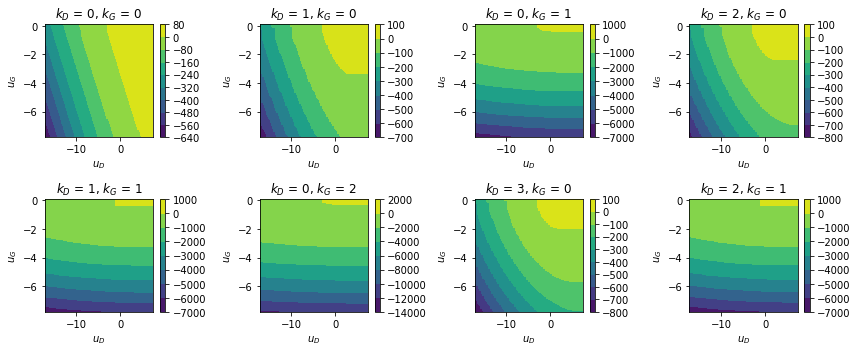

In [258]:
results = load_k_results(1)

plt.figure(figsize=(12,5));

results = sorted(results, key=lambda r: r[0]+r[1])
for i, res in enumerate(results[:8]):
    plt.subplot(2, 4, i+1)
    plt.contourf(res[-2], res[-1], res[-3]);
    plt.colorbar();
    plt.title("$k_D$ = {}, $k_G$ = {}".format(res[0],res[1]))
    plt.xlabel('$u_D$');
    plt.ylabel('$u_G$');
plt.tight_layout();

plt.savefig("figures/theta_indexs.pdf")

In [353]:
from numba import jit, njit

def fast_transform_k_data(results):
    kd_array = []
    kg_array = []
    for r in results:
        pos = r[-3] > 0
        kdarr = pos*r[0]
        kgarr = pos*r[1]
        kdarr = kdarr - (~pos)
        kgarr = kgarr - (~pos)
        kd_array.append(kdarr)
        kg_array.append(kgarr)
    kd_array = np.array(kd_array)
    kg_array = np.array(kg_array)
    kd_inds = np.max(kd_array, axis=0)
    kg_inds = np.max(kg_array, axis=0)
    return results[0][-2], results[0][-1], kd_inds, kg_inds
                    
def contour_plot_ks(kd_inds, kg_inds, uD, uG, lower_x=-4, lower_y=-4, zoom_x=(-4, 0), zoom_y=(-.5, 1),
                   kd_cmap_step=2, kg_cmap_step=2, zoom=True):
    plt.figure(figsize=(14 if zoom else 7, 6))

    
    ax = plt.subplot(1, 2 if zoom else 1, 1)

    kdcmap = [cm.get_cmap('inferno', 128)(i) for i in range(0, 128, kd_cmap_step)]
    kgcmap = [cm.get_cmap('viridis', 128)(i) for i in range(0, 128, kg_cmap_step)]
    cont1 = ax.contour(uDs, uGs, kd_inds, np.unique(np.abs(kd_inds))[::2], colors=kdcmap);
    cont2 = ax.contour(uDs, uGs, kg_inds, np.unique(np.abs(kg_inds))[::2], colors=kgcmap);
    cont1.clabel(fmt="%d", fontsize=15)
    cont2.clabel(fmt="%d", fontsize=15)

    if lower_x is not None:
        ax.set_xlim([lower_x, np.max(uD)]);
    if lower_y is not None:
        ax.set_ylim([lower_y, np.max(uG)]);
    ax.set_xlabel("$u_D$");
    ax.set_ylabel("$u_G$");


    if zoom:
        ax = plt.subplot(1, 2, 2)
        cont1 = ax.contour(uDs, uGs, kd_inds, np.unique(kd_inds)[::2], colors=kdcmap);
        cont2 = ax.contour(uDs, uGs, kg_inds, np.unique(kg_inds)[1::2], colors=kgcmap);

        ax.set_xlim(zoom_x)
        ax.set_ylim(zoom_y)
        cont1.clabel(fmt="%d", fontsize=15);
        cont2.clabel(fmt="%d", fontsize=15);


        ax.set_xlabel("$u_D$");
        ax.set_ylabel("$u_G$");

In [ ]:
results = load_k_results(1)
uDs = results[0][-2]
uGs = results[0][-1]
uD, uG, kd_inds, kg_inds = fast_transform_k_data(results)

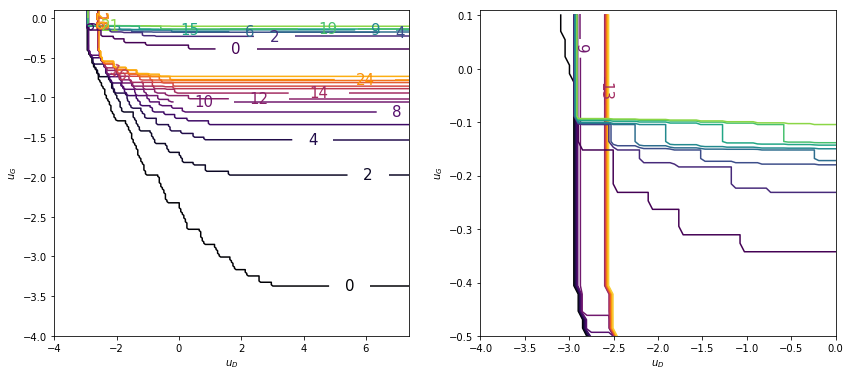

In [328]:
zoom_y = (-0.5, 0.11)
contour_plot_ks(kd_inds, kg_inds, uD, uG, zoom_y=zoom_y)
plt.savefig("figures/kd_kg_strcture_contour.pdf");

Using -1 to represent no possible critical points works better with the interpolation for the plotting of these contours. For filled contour plots, it is much easier to visualise if we use `-np.inf`, as this is omitted from the contour, showing up the unfeasible regions as white.

In [356]:
def plot_filled_contour_ks(kd_inds, kg_inds, uD, uG, lower_x=-4, lower_y=-4):
    fig = plt.figure(figsize=(10,4))

    _kd_inds = kd_inds[:].astype(float)
    _kd_inds[kd_inds==-1] = -np.inf
    _kg_inds = kg_inds[:].astype(float)
    _kg_inds[kg_inds==-1] = -np.inf
    ax = plt.subplot(1, 2, 1)
    cont1 = ax.contourf(uDs, uGs, _kd_inds);

    ax.set_xlim([lower_x, np.max(uD)]);
    ax.set_ylim([lower_y, np.max(uG)]);
    ax.set_xlabel("$u_D$");
    ax.set_ylabel("$u_G$");
    ax.set_title("$k_D$")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.15)

    fig.colorbar(cont1, cax=cax, orientation='vertical');

    ax = plt.subplot(1, 2, 2)

    cont2 = ax.contourf(uDs, uGs, _kg_inds);
    ax.set_xlim([lower_x, np.max(uD)]);
    ax.set_ylim([lower_y, np.max(uG)]);
    
    ax.set_xlabel("$u_D$");
    ax.set_ylabel("$u_G$");
    ax.set_title("$k_G$")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.15)

    fig.colorbar(cont2, cax=cax, orientation='vertical');
    plt.tight_layout()


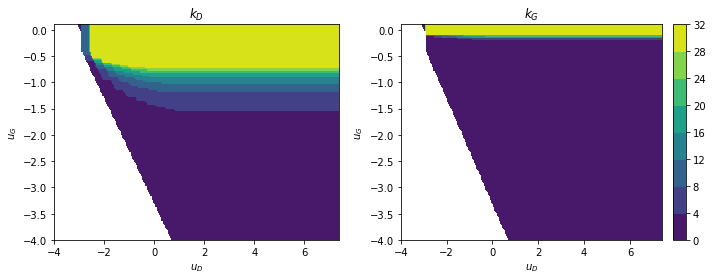

In [330]:
plot_filled_contour_ks(kd_inds, kg_inds, uD, uG)
plt.savefig("figures/kd_kg_filled_contours.pdf");

We have $k_D, k_G$ results for various $\sigma_z$ values.

In [342]:
sigma = 1e-1
results = load_k_results(sigma)
uDs = results[0][-2]
uGs = results[0][-1]
uD, uG, kd_inds, kg_inds = fast_transform_k_data(results)

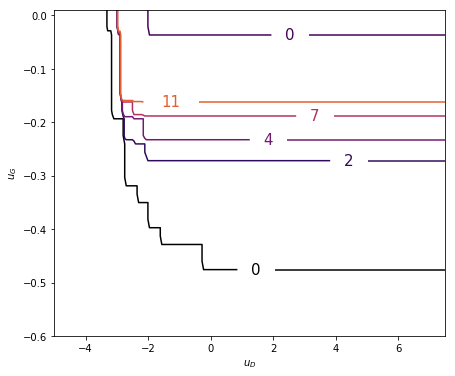

In [354]:
lower_x = -5
lower_y = -.6
zoom_x = (-4.5, 6)
zoom_y = (-0.4, 0)
contour_plot_ks(kd_inds, kg_inds, uD, uG, lower_x=lower_x, lower_y=lower_y, zoom_x=zoom_x, zoom_y=zoom_y,
                kd_cmap_step=20, zoom=False)
plt.savefig("figures/kd_kg_strcture_contour_sigma_{:.5f}.pdf");

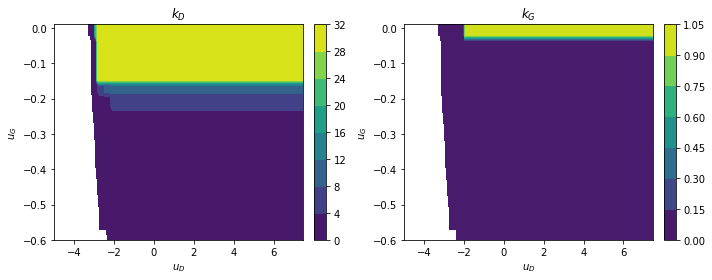

In [357]:
plot_filled_contour_ks(kd_inds, kg_inds, uD, uG, lower_x=lower_x, lower_y=lower_y)
plt.savefig("figures/kd_kg_filled_contours_sigma_{:.5f}.pdf");

In [358]:
sigma = 30
results = load_k_results(sigma)
uDs = results[0][-2]
uGs = results[0][-1]
uD, uG, kd_inds, kg_inds = fast_transform_k_data(results)

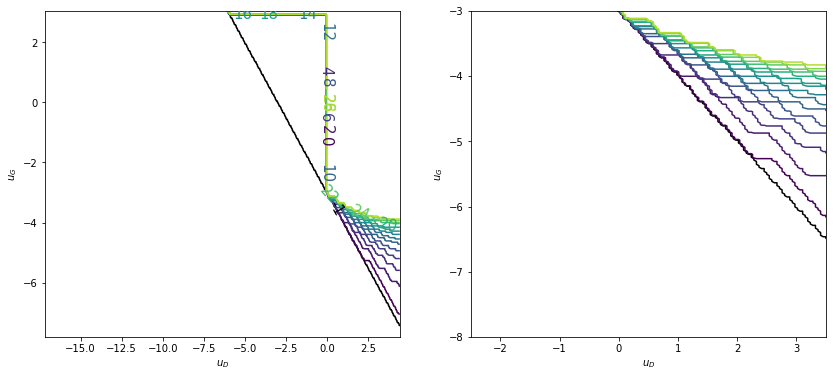

In [362]:
lower_x = None
lower_y = None
zoom_x = (-2.5, 3.5)
zoom_y = (-8, -3)
contour_plot_ks(kd_inds, kg_inds, uD, uG, lower_x=lower_x, lower_y=lower_y, zoom_x=zoom_x, zoom_y=zoom_y,
                kg_cmap_step=8, kd_cmap_step=20)
                
plt.savefig("figures/kd_kg_strcture_contour_sigma_{:.5f}.pdf");

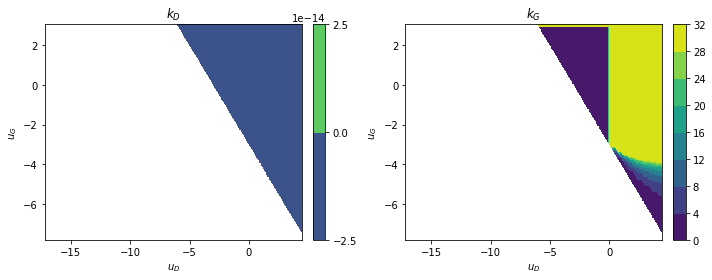

In [363]:
plot_filled_contour_ks(kd_inds, kg_inds, uD, uG, lower_x=lower_x, lower_y=lower_y)
plt.savefig("figures/kd_kg_filled_contours_sigma_{:.5f}.pdf");

## Effect of $\sigma_z$

From the ML motivation, we expect an optimal $\sigma_z$. We can consider the following quantities within the complexity theory:

1. $\min\{u_D \mid \exists u_G ~:~ \Theta(u_D, u_G) > 0\}$
2. $\min\{u_G \mid \exists u_D ~:~ \Theta(u_D, u_G) > 0\}$
3. $\min\{u_D+u_G \mid \Theta(u_D, u_G) > 0\}$

Since the $u_D, u_G$ are constructed as upper bounds on the networks losses, we naturally wish to minimize them, and $\Theta >0$ is required for the existence of low-rank saddles below those upper bound losses.

We will now vary $\sigma_z$ and pull out these values.

In [25]:
p, q, kappa = 2, 2, 0.9
kD, kG = 0, 0
sigma_zs = np.logspace(-5, 2, 60)
min_uDs = []
min_uGs = []
min_sums = []
max_vals = []


x = np.linspace(-15, 35, 75)
x1 = np.linspace(-15, 10, 75)
x, x1 = np.meshgrid(x, x1)

def worker(sigma_z):
    b, b1 = b_constants(p, q, sigma_z, kappa)
    C = complexity_constant(p, q, sigma_z, kappa)
    s_sq, s1_sq = univariate_gaussian_variances(p, q, sigma_z)

    exp = np.vectorize(partial(log_complexity_exponent, b=b, b1=b1, kappa=kappa, constant=C, s_sq=s_sq, s1_sq=s1_sq))
    e = exp(x, x1)
    uD, uG, T = theta(x, x1, np.real(e), p, q)
#     max_vals.append((sigma_z, np.max(T[~np.isnan(T)])))
    Tps = np.vstack(np.where(T > 0)).T
    uzs = [uD[Tp[0], Tp[1]] for Tp in Tps]
    if uzs:
        min_uD =  np.min(uzs)
    uzs = [uG[Tp[0], Tp[1]] for Tp in Tps]
    if uzs:
        min_uG =  np.min(uzs) 
    uzs = [uD[Tp[0], Tp[1]] + uG[Tp[0], Tp[1]] for Tp in Tps]
    if uzs:
        min_sum = np.min(uzs)
    return min_uD, min_uG, min_sum, sigma_z

results = np.array(Parallel(n_jobs=-1, verbose=1)((delayed(worker)(sigma_z) for sigma_z in sigma_zs)))

min_uDs = results[:, 0]
min_uGs = results[:, 1]
min_sums = results[:, 2]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed: 27.4min remaining: 200.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 44.5min finished


**Alternatively** load the data (here the data has been produced on an HPC).

In [372]:
results_loc = "/work/jr19127/gan-loss-surfaces/rmt_results/vary_sigma_pq55/"
result_fns = sorted(os.listdir(results_loc), key=lambda s: int(s.split("_")[1]))
results = []
for fn in result_fns:
    with open(os.path.join(results_loc, fn), "rb") as fin:
        results.append([x if x is not None else np.nan for x in pkl.load(fin)])
results = np.array(results)

sigma_zs = results[:, 0]
min_uDs = results[:, 1]
min_uGs = results[:, 2]
min_sums = results[:, 3]

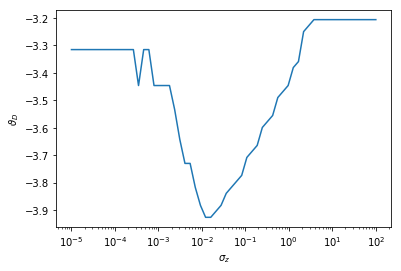

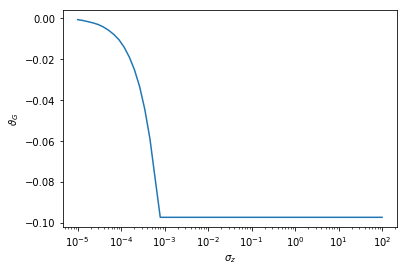

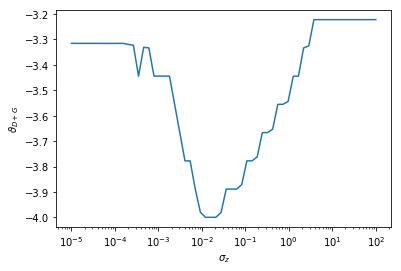

In [373]:
for i, (u_vals, name) in enumerate(zip([min_uDs, min_uGs, min_sums], ["D", "G", "D + G"])):
    plt.figure();
    plt.plot(sigma_zs, u_vals);
    plt.xlabel("$\sigma_z$");
    plt.xscale('log');
    plt.ylabel("$\\vartheta_{{{}}}$".format(name));
    plt.savefig("figures/sigma_z_effect_{}.pdf".format(i));

## Effect of $\kappa$

From the ML motivation, we expect an optimal $\kappa$. We can consider the following quantities within the complexity theory:

1. $\min\{u_D \mid \exists u_G ~:~ \Theta(u_D, u_G) > 0\}$
2. $\min\{u_G \mid \exists u_D ~:~ \Theta(u_D, u_G) > 0\}$
3. $\min\{u_D+u_G \mid \Theta(u_D, u_G) > 0\}$

Since the $u_D, u_G$ are constructed as upper bounds on the networks losses, we naturally wish to minimize them, and $\Theta >0$ is required for the existence of low-rank saddles below those upper bound losses.

We will now vary $\kappa$ and pull out these values.

In [8]:
p, q, sigma_z = 2, 2, 0.1
kD, kG = 0, 0
kappas = np.linspace(0.01, 0.99, 50)
min_uDs = []
min_uGs = []
min_sums = []
max_vals = []


x = np.linspace(-15, 35, 75)
x1 = np.linspace(-15, 10, 75)
x, x1 = np.meshgrid(x, x1)

def worker(kappa):
    b, b1 = b_constants(p, q, sigma_z, kappa)
    C = complexity_constant(p, q, sigma_z, kappa)
    s_sq, s1_sq = univariate_gaussian_variances(p, q, sigma_z)

    exp = np.vectorize(partial(log_complexity_exponent, b=b, b1=b1, kappa=kappa, constant=C, s_sq=s_sq, s1_sq=s1_sq))
    e = exp(x, x1)
    uD, uG, T = theta(x, x1, np.real(e), p, q)
#     max_vals.append((sigma_z, np.max(T[~np.isnan(T)])))
    Tps = np.vstack(np.where(T > 0)).T
    uzs = [uD[Tp[0], Tp[1]] for Tp in Tps]
    if uzs:
        min_uD =  np.min(uzs)
    else:
        min_uD = np.nan
    uzs = [uG[Tp[0], Tp[1]] for Tp in Tps]
    if uzs:
        min_uG =  np.min(uzs) 
    else:
        min_uG = np.nan
    uzs = [uD[Tp[0], Tp[1]] + uG[Tp[0], Tp[1]] for Tp in Tps]
    if uzs:
        min_sum = np.min(uzs)
    else:
        min_sum = np.nan
    return min_uD, min_uG, min_sum, kappa

results = np.array(Parallel(n_jobs=-1, verbose=1)((delayed(worker)(kappa) for kappa in kappas)))

min_uDs = results[:, 0]
min_uGs = results[:, 1]
min_sums = results[:, 2]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  50 | elapsed: 36.4min remaining: 266.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 55.8min finished


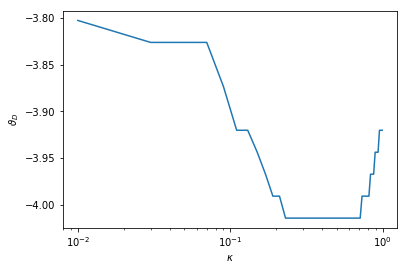

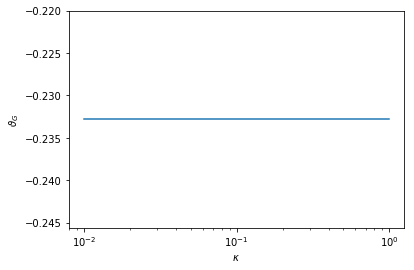

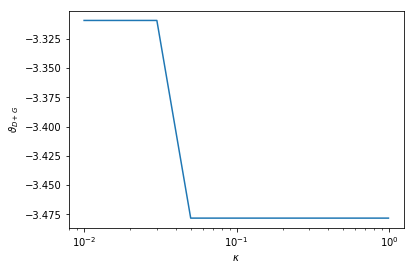

In [9]:
for i, (u_vals, name) in enumerate(zip([min_uDs, min_uGs, min_sums], ["D", "G", "D + G"])):
    plt.figure();
    plt.plot(kappas, u_vals);
    plt.xlabel("$\kappa$");
    plt.xscale('log');
    plt.ylabel("$\\vartheta_{{{}}}$".format(name));
    plt.savefig("figures/kappa_effect_{}.pdf".format(i));